# Cetane

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.svm import SVR
from skopt import gp_minimize
from skopt.plots import plot_convergence



C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [118]:
df = pd.read_table(r'C:\Users\zcemg08\Desktop\important\2139456\ef200795j_si_002\Models\CN\MD\MD.txt')
svm_vec = pd.read_table(r'C:\Users\zcemg08\Desktop\important\2139456\ef200795j_si_002\Models\CN\MD\SVM\support_vectors.txt',header=None)
cn_data = pd.read_excel(r'C:\Users\zcemg08\Desktop\important\2139456\cn_data.xls')

df_cetane = df[df['Property'].notnull()]
cn_data   = cn_data[cn_data['CN Exp.'].notnull()]

In [8]:
col = list(cn_data)[39:]
x_train_validate = cn_data[cn_data['Set (CN)'].isin(['Training','Validation'])][col].values
y_train_validate = cn_data[cn_data['Set (CN)'].isin(['Training','Validation'])]['CN Exp.'].values

scaler = StandardScaler()

x_train_validate = scaler.fit_transform(x_train_validate)



In [9]:
len(col)

194

In [15]:
cn_data['Family'].unique()

array(['Alcohols', 'Aromatics', 'Esters', 'Naphtenes', 'Olefins',
       'Paraffins'], dtype=object)

In [5]:
reg = SVR(gamma='auto')

# Build step forward feature selection
sfs1 = sfs(reg,
           k_features=20,
           forward=True,
           floating=False,
           verbose=0,
           scoring='neg_mean_squared_error',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(x_train_validate, y_train_validate)

index = np.array(sfs1.k_feature_idx_)
selected_features = np.take(col,index)
found_features = list(df)[4:]

a = set(found_features)
b = set(selected_features)

print ('Number of common features found {}'.format(len(a.intersection(b))))

Number of common features found 4


# Build Model 

In [13]:
col = selected_features
x_train_validate = cn_data[cn_data['Set (CN)'].isin(['Training','Validation'])][col].values
y_train_validate = cn_data[cn_data['Set (CN)'].isin(['Training','Validation'])]['CN Exp.'].values


scaler = StandardScaler()

x_train_validate = scaler.fit_transform(x_train_validate)

x_test = cn_data[cn_data['Set (CN)']=='Test'][col].values
x_test = scaler.transform(x_test)
y_test = cn_data[cn_data['Set (CN)']=='Test']['CN Exp.'].values


reg = SVR(gamma='auto')

space  = [Real(10**-3, 10**3, "log-uniform", name='C'),
          Real(10**-2, 10**2,"log-uniform", name='gamma')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, x_train_validate, y_train_validate, cv=10, n_jobs=-1,
                                    scoring="r2"))

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


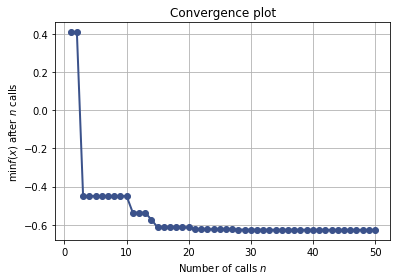

In [14]:
plot_convergence(res_gp)

In [17]:
reg.C = res_gp.x[0]
reg.gamma = res_gp.x[1]

reg.fit(x_train_validate,y_train_validate)

SVR(C=134.43112721338278, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.01, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [18]:
print ('RMSE = {}'.format(np.sqrt(mean_squared_error(y_test, reg.predict(x_test)))))
print ('R2 = {}'.format(r2_score(reg.predict(x_test),y_test)))

RMSE = 5.856579696336973
R2 = 0.9390485132135491


In [19]:
col

array(['Molecular.flexibility..Fast.Descriptors.',
       'Kappa.3..Fast.Descriptors.',
       'Kappa.2..alpha.modified...Fast.Descriptors.',
       'Kappa.3..alpha.modified...Fast.Descriptors.',
       'Subgraph.counts..3...cluster..Fast.Descriptors.',
       'E.state.keys..sums...S_ssCH2..Fast.Descriptors.',
       'E.state.keys..sums...S_dsCH..Fast.Descriptors.',
       'E.state.keys..sums...S_ddC..Fast.Descriptors.',
       'E.state.keys..sums...S_aaO..Fast.Descriptors.',
       'Shadow.area..YZ.plane..Spatial.Descriptors.',
       'Shadow.length..LX..Spatial.Descriptors.',
       'Shadow.length..LY..Spatial.Descriptors.',
       'Shadow.ratio..Spatial.Descriptors.', 'DPSA1..Jurs.Descriptors.',
       'FPSA1..Jurs.Descriptors.', 'Carboxylic.Acid..Fragment.Counts.',
       'Glycerol..Fragment.Counts.', 'Glycol..Fragment.Counts.',
       'Isobutyl..Fragment.Counts.', 'Cyclohexane..Fragment.Counts.'],
      dtype='<U63')

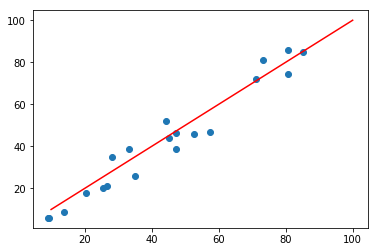

In [24]:
plt.scatter(reg.predict(x_test),y_test)

x = np.linspace(10,100)
y = x

plt.plot(x, y, '-r', label='ideal')
plt.show()

In [79]:
from mordred import Calculator, descriptors


    # Create empty Calculator instance
calc = Calculator(descriptors, ignore_3D=False)



In [80]:
mols = [Chem.MolFromSmiles(smi) for smi in list(cn_data['SMILES'].values)]

In [81]:
df = calc.pandas(mols)

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 329/329 [00:16<00:00, 20.33it/s]


In [85]:
df['index'] = np.arange(0,329)
df1 = cn_data[['Name','SMILES','Set (CN)','CN Exp.']]


In [87]:
df1 = cn_data[['Name','SMILES','Set (CN)','CN Exp.']]
df1['index'] = np.arange(0,329)
df1

C:\Users\zcemg08\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Name,SMILES,Set (CN),CN Exp.,index
4,"(9Z,12Z,15Z)-octadeca-9,12,15-trien-1-ol",OCCCCCCCC/C=C\C/C=C\C/C=C\CC,Training,41.0,0
5,"(9Z,12Z)-octadeca-9,12-dien-1-ol",CCCCC/C=C\C/C=C\CCCCCCCCO,Validation,44.0,1
6,(9Z)-hexadec-9-en-1-ol,CCCCCC/C=C\CCCCCCCCO,Test,46.0,2
7,(9Z)-octadec-9-en-1-ol,CCCCCCCC/C=C\CCCCCCCCO,Training,51.0,3
32,2(R)-ethylhexan-1-ol,CCCC[C@@H](CC)CO,Training,23.4,4
...,...,...,...,...,...
1154,n-pentane,CCCCC,Training,30.0,324
1155,n-propane,CCC,Unreliable,-20.0,325
1156,n-tetradecane,CCCCCCCCCCCCCC,Training,95.0,326
1157,n-tridecane,CCCCCCCCCCCCC,Validation,90.0,327


In [89]:
df_descriptors = df1.merge(df,on=['index'] ,how='left')

In [97]:
df_descriptors = df_descriptors.loc[:, (df_descriptors != df_descriptors.iloc[0]).any()] 
df_descriptors = df_descriptors.drop(['index'],axis=1)

In [102]:
df_descriptors = df_descriptors.loc[:,~df_descriptors.columns.duplicated()]

df_descriptors = df_descriptors.dropna(axis=1, how='all')

In [103]:
df_descriptors

,Name,SMILES,Set (CN),CN Exp.,ABC,ABCGG,nAcid,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,"(9Z,12Z,15Z)-octadeca-9,12,15-trien-1-ol",OCCCCCCCC/C=C\C/C=C\C/C=C\CC,Training,41.0,12.727922,10.180005,0,23.412409,1.975377,3.950753,...,8.298291,48.426412,264.245316,5.181281,1140,16,70.0,68.0,6.250000,5.00
1,"(9Z,12Z)-octadeca-9,12-dien-1-ol",CCCCC/C=C\C/C=C\CCCCCCCCO,Validation,44.0,12.727922,10.180005,0,23.412409,1.975377,3.950753,...,8.298291,48.426412,266.260966,5.023792,1140,16,70.0,68.0,6.250000,5.00
2,(9Z)-hexadec-9-en-1-ol,CCCCCC/C=C\CCCCCCCCO,Test,46.0,11.313708,9.412260,0,20.860105,1.969616,3.939231,...,8.164226,45.799808,240.245316,4.902966,816,14,62.0,60.0,5.750000,4.50
3,(9Z)-octadec-9-en-1-ol,CCCCCCCC/C=C\CCCCCCCCO,Training,51.0,12.727922,10.180005,0,23.412409,1.975377,3.950753,...,8.298291,48.426412,268.276616,4.877757,1140,16,70.0,68.0,6.250000,5.00
4,2(R)-ethylhexan-1-ol,CCCC[C@@H](CC)CO,Training,23.4,5.656854,6.142781,0,10.565187,2.042079,4.084158,...,7.884953,35.263065,130.135765,4.819843,104,8,32.0,32.0,4.361111,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,n-pentane,CCCCC,Training,30.0,2.828427,3.146264,0,5.464102,1.732051,3.464102,...,6.192362,25.583106,72.093900,4.240818,20,2,14.0,12.0,2.750000,1.50
325,n-propane,CCC,Unreliable,-20.0,1.414214,1.414214,0,2.828427,1.414214,2.828427,...,4.174387,17.310771,44.062600,4.005691,4,0,6.0,4.0,2.250000,1.00
326,n-tetradecane,CCCCCCCCCCCCCC,Training,95.0,9.192388,8.164909,0,17.133544,1.956295,3.912590,...,7.921898,41.681626,198.234751,4.505335,455,11,50.0,48.0,5.000000,3.75
327,n-tridecane,CCCCCCCCCCCCC,Validation,90.0,8.485281,7.718011,0,15.750491,1.949856,3.899712,...,7.826044,40.245095,184.219101,4.493149,364,10,46.0,44.0,4.750000,3.50


In [107]:
num_cols = df_descriptors._get_numeric_data().columns

In [110]:
num_cols

Index(['CN Exp.', 'ABC', 'ABCGG', 'nAcid', 'SpAbs_A', 'SpMax_A', 'SpDiam_A',
       'SpAD_A', 'SpMAD_A', 'LogEE_A',
       ...
       'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=889)

In [111]:
df_test = df_descriptors[num_cols]

In [119]:
df_test['Set (CN)'] = cn_data['Set (CN)']

C:\Users\zcemg08\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [121]:
df_test['Set (CN)']

0           NaN
1           NaN
2           NaN
3           NaN
4      Training
         ...   
324         NaN
325         NaN
326         NaN
327         NaN
328         NaN
Name: Set (CN), Length: 329, dtype: object

In [115]:
col = list(df_test)[1:]

In [116]:
cn_data = df_test

x_train_validate = cn_data[cn_data['Set (CN)'].isin(['Training','Validation'])][col].values
y_train_validate = cn_data[cn_data['Set (CN)'].isin(['Training','Validation'])]['CN Exp.'].values

scaler = StandardScaler()

x_train_validate = scaler.fit_transform(x_train_validate)


KeyError: 'Set (CN)'